fig = px.scatter(df, x="total_bill", y="tip", trendline="ols")
fig.show()# TeamBadass Milestone 2

This notebook intends to explore and describe the relevant aspects of our data sets, preprocess it, and perform some initial analysis. The first part of the notebook contains the loading of data and some general preprocessing used throughout the notebook. The rest of the notebook is divided into the five research questions specified in [**README**](https://github.com/epfl-ada/ada-2022-project-teambadass/blob/main/README.md). Each section contains specific preprocessing for the task and necessary statistics and plots. The initial analysis we have performed intends to give us a clue whether our choice of methods is reasonable and sound. 

---
**Contents of notebook:**
- [Data Processing](#Data-Processing)
  - [Loading data](#Loading-data)
  - [Removing null values](#Removing-null-values)
- [Release Date](#Release-Date)
  - [Data Processing](#Data-Processing)
  - [Plots - Year](#Plots---Year)
  - [Plots - Month](#Plots---Month)
  - [Adjusting for Inflation](#Adjusting-for-Inflation)
  - [Statistics](#Statistics)
- [Diversity](#Diversity)
  - [Distributions](#Distributions)
  - [Ethnicities](#Ethnicities)
- [Cast](#Cast)
  - [Preprocessing](#Preprocessing)
  - [Understanding Cast Data](Understanding-Cast-Data)
  - [Exploring Method: Linear Regression](#Exploring-Method:-Linear-Regression)
- [Runtime](#Runtime)
  - [Data Preprocessing](#Data-Preprocessing)
  - [Distribution of runtime](#Distribution-of-runtime)
  - [Regression & Scatterplot](#Regression-&-Scatterplot)
  - [Effect of short runtime on revenue](#Effect-of-short-runtime-on-revenue)
  - [Difference in runtime between blockbuster vs. non-blockbuster](#Difference-in-runtime-between-blockbuster-vs.-non-blockbuster)
- [Plot Summary](#Plot-Summary)
  - [Data Processing](#Data-Processing)
  - [Regression & Scatterplot](#Regression-&-Scatterplot)
  - [Difference in revenues between movies with more positive and more negative plot](#Difference-in-revenues-between-movies-with-more-positive-and-more-negative-plot)
  - [Difference in sentiment proportion between blockbuster vs. non-blockbuster](#Difference-in-sentiment-proportion-between-blockbuster-vs.-non-blockbuster)

---
## Data Processing

---
### Loading data

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import requests
from datetime import datetime as dt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from helpers import *

In [2]:
# turn off warning
# pd.options.mode.chained_assignment = None

In [3]:
# constants

# data folder
DATA_FOLDER = "./data/"

# google disk
MOVIE_PATH = get_path(
    "https://drive.google.com/file/d/18ZLIKZsH41qls54Gy1qSYW1xtovf9Ke9/view?usp=share_link"
)
CHARACTER_PATH = get_path(
    "https://drive.google.com/file/d/1b3_Jn3bBJl6prrtPagU-Yol-ijFMod2u/view?usp=share_link"
)
RATING_PATH = get_path(
    "https://drive.google.com/file/d/1Dj5PhOERTTv6zZDprLIQMMaot3JYFlWi/view?usp=share_link"
)
BUDGET_PATH = get_path(
    "https://drive.google.com/file/d/1pV-iP36u1wmELu3AOLPNZ7rJJGsgj7YB/view?usp=share_link"
)
INFLATION_PATH = get_path(
    "https://drive.google.com/file/d/1k5DganllAAzXHTMLQvatpsdYy7LTlubW/view?usp=share_link"
)
PLOT_SUMMARIES_PATH = get_path(
    "https://drive.google.com/file/d/1SfJVQcRFxIaH1qfNSlu9llLK6e4TB_Bi/view?usp=share_link"
)


# local files
IMDB_MOVIES_PATH = DATA_FOLDER + "title.basics.tsv"
VIOLENT_WORDS_PATH = DATA_FOLDER + "violent_word_list.txt"

# requests
POSITIVE_WORDS_PATH = "https://ptrckprry.com/course/ssd/data/positive-words.txt"

In [4]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)
budget = pd.read_csv(
    BUDGET_PATH, usecols=["id", "budget", "original_title", "release_date", "runtime"]
)

imdb_movies = pd.read_table(
    IMDB_MOVIES_PATH,
    sep="\t",
    usecols=["tconst", "originalTitle", "startYear", "runtimeMinutes"],
)
imdb_ratings = pd.read_table(RATING_PATH, sep="\t")

---
### Merging the dataframes

Movie.metadata.tsv identifies the movies with wikipedia ID, while the IMDB datasets use their own ID and the Kaggle dataset use another ID. We will use (movie name, release year, runtime) as an ID for merging the dataframes. (movie_name, release_year, runtime) makes an almost unique identifier in each of the datasets. In the cases where there are duplicates of this subset, they represent the same movie. 

In [5]:
# adding column for release year in movies and budget dataframes.
# IMDb dataset already contains release year.
movies["year_released"] = pd.to_datetime(
    movies["movie_release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

budget["year_released"] = pd.to_datetime(
    budget["release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

# removing rows with null values in year_released
movies = movies[~movies["year_released"].isna()]

# renaming column names to match ('movie_name', 'release_year', 'movie_runtime') between the datasets
imdb_movies = imdb_movies.rename(
    columns={
        "startYear": "year_released",
        "originalTitle": "movie_name",
        "runtimeMinutes": "movie_runtime",
    }
)
budget = budget.rename(
    columns={"original_title": "movie_name", "runtime": "movie_runtime"}
)

# converting '\\N' values to np.nan
budget.loc[budget["year_released"] == "\\N", "year_released"] = np.nan
budget.loc[budget["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

imdb_movies.loc[imdb_movies["year_released"] == "\\N", "year_released"] = np.nan
imdb_movies.loc[imdb_movies["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

# removing all rows containing np.nan
budget = budget[budget["year_released"].notna()]
imdb_movies = imdb_movies[imdb_movies["year_released"].notna()]

# converting year released to 'int64'
movies["year_released"] = movies["year_released"].astype("int64")
budget["year_released"] = budget["year_released"].astype("int64", errors="ignore")
imdb_movies["year_released"] = imdb_movies["year_released"].astype("int64")

# converting runtime to 'float64'
budget["movie_runtime"] = budget["movie_runtime"].astype("float64")
imdb_movies["movie_runtime"] = imdb_movies["movie_runtime"].astype(
    "float64", errors="ignore"
)

In [6]:
# removing rows with duplicate of ('movie_name', 'release_year', 'movie_runtime') in movies
movies = movies.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
budget = budget.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
imdb_movies = imdb_movies.drop_duplicates(
    subset=["movie_name", "year_released", "movie_runtime"]
)

In [7]:
# merge 'movies' with 'budget'
movies = pd.merge(
    left=movies,
    right=budget,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)

# merge 'imdb_movies' with 'imdb_ratings':
imdb_movies = pd.merge(left=imdb_movies, right=imdb_ratings, on="tconst")

# merge 'movies' with 'imdb_movies' + 'imdb_ratings'
movies = pd.merge(
    left=movies,
    right=imdb_movies,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)

In [8]:
# convert budget to float
movies["budget"] = movies["budget"].astype("float")

In [9]:
# print the 'movie' data frame
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,budget,id,release_date,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,28000000.0,10016,2001-08-24,tt0228333,4.9,55271.0


In [10]:
# print the 'characters' data frame
characters.head(1)

,wikipedia_movie_ID,freebase_movie_ID,last_update,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


---
### Removing null values
This notebook intends to investigate the how different features effect the revenue; we will therefore filter out movies without `Movie box office revenue.`

In [11]:
# filtering out movies without revenue
num_movies_before_filter = movies.shape[0]
movies = movies[~movies["movie_box_office_revenue"].isna()]
num_movies_after_filter = movies.shape[0]

# printing the results
print(
    f"""
Total number of movies before filtering: {num_movies_before_filter}
Number of movies after filtering:         {num_movies_after_filter}     
"""
)


Total number of movies before filtering: 74821
Number of movies after filtering:         8325     



#### Comment
- We observe that ~90% of the movies were filtered out.
- We still got 8 325 which should be sufficient for the data analysis.

---
# Release Date
- This section intends to investigate the runtime of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the distribution of release dates and how these correlate with a movie's revenue.

---
### Summary
In summary, we found a positive correlation between release year and box office revenue, and between release month and box office revenue. Because of inflation we need to be careful to interpret the increasing revenues over the year and the positive correlation. With regard to the month, we found significant differences in the mean box office revenue. The most promising month is June in terms of box office revenue. 


---
### Data Processing

In [12]:
# column that idicate if date were given or only year
movies["date_given"] = movies["release_date"].apply(lambda x: is_given_date(str(x)))

In [13]:
# transform the string representation to date-time representation
movies["release_date"] = pd.to_datetime(
    movies["release_date"], errors="coerce", utc=True
)

# extract year and month (if no month are given the default is set to January)
movies["release_year"] = pd.DatetimeIndex(movies["release_date"]).year
movies["release_month"] = pd.DatetimeIndex(movies["release_date"]).month

# filter out movies without release date
movies = movies[movies["release_date"].notna()]

### Plots - Year

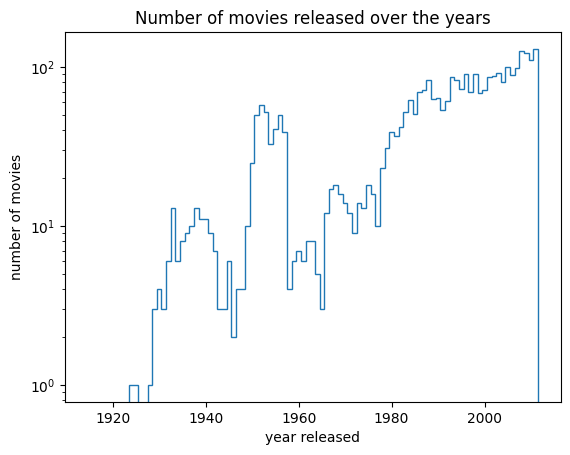

In [14]:
# plot the distribution of realese years
bins = np.arange(1915, 2013) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["year_released"], histtype="step", bins=bins, log=True)
plt.title("Number of movies released over the years")
plt.xlabel("year released")
plt.ylabel("number of movies")
plt.show()

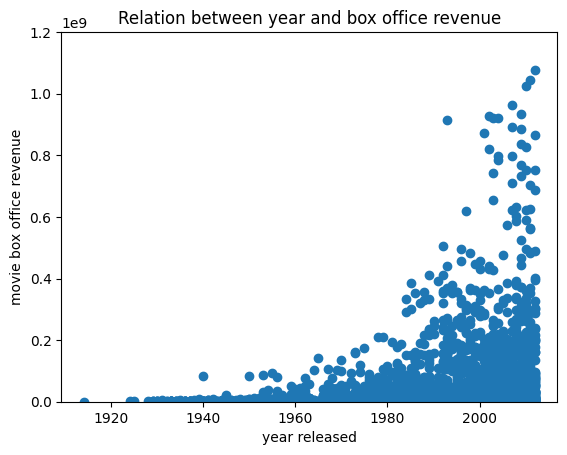

In [15]:
# plot the relation between year released and revenue
plt.scatter(movies["year_released"], movies["movie_box_office_revenue"])
plt.title("Relation between year and box office revenue")
plt.xlabel("year released")
plt.ylabel("movie box office revenue")

# removing outlier for better visualization
plt.ylim(0, 1.2e9)
plt.show()

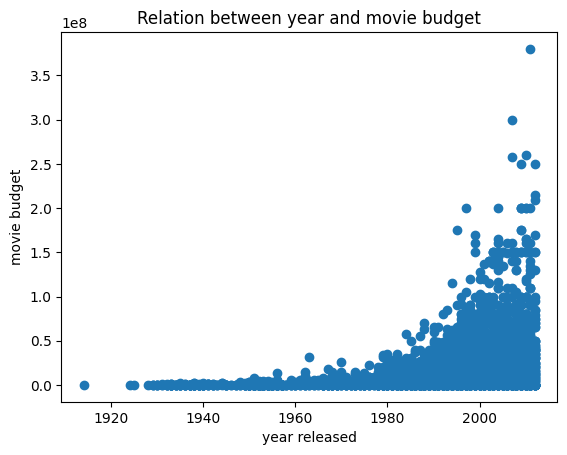

In [16]:
# plot the relation between year released and budget after adjusting for inflation
plt.scatter(movies["year_released"], movies["budget"])
plt.title("Relation between year and movie budget")
plt.xlabel("year released")
plt.ylabel("movie budget")
plt.show()

#### Comment

**Problem:**
- We observe that the dataset contains some old movies. The revenue and the budget will not be representable for such movies because of inflation.


**Solution:**
- A possible solution is to collect a dataset of the inflation and adjust the revenue and the budget for inflation to make them comparable.

**Conclusion:**
- We collect an external dataset on inflation. We use the Headline Consumer Price Index (CPI) of the United States to adjust for inflation from 1960 to 2014.

### Plots - Month

In [17]:
# filter out movies without given data, these were given January as default value
month_data = movies[movies["date_given"]]

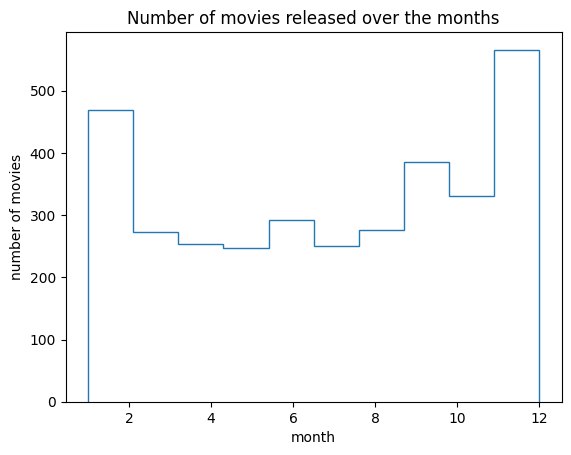

In [18]:
# plot number of movies released over the months
plt.hist(month_data["release_month"], histtype="step", bins=10)
plt.title("Number of movies released over the months")
plt.xlabel("month")
plt.ylabel("number of movies")
plt.show()

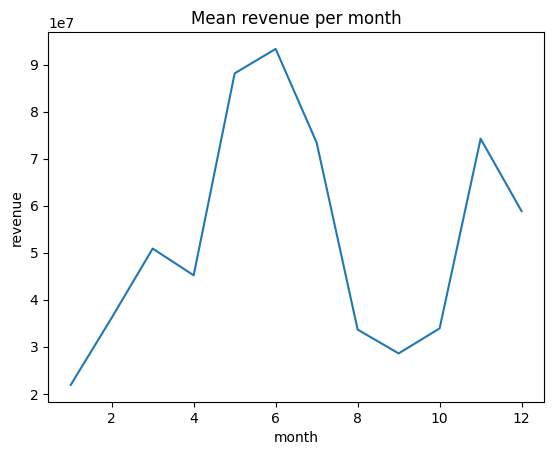

In [19]:
# plot mean revenue for each month
plt.plot(month_data.groupby(["release_month"])["movie_box_office_revenue"].mean())
plt.title("Mean revenue per month")
plt.xlabel("month")
plt.ylabel("revenue")
plt.show()

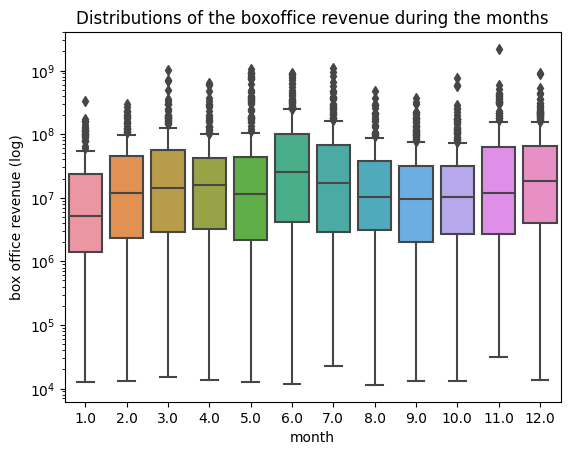

In [20]:
# boxplot of the revenues for each month
sns.boxplot(x="release_month", y="movie_box_office_revenue", data=movies)
plt.title("Distributions of the boxoffice revenue during the months")
plt.xlabel("month")
plt.ylabel("box office revenue (log)")
plt.yscale("log")
plt.show()

#### Comment

- We observe that January and December has the highest frequency of releases.
- We also observe significant variation in the mean revenue for each month.

---
### Adjusting for Inflation

Our previous finding suggested that we had to adjust the `movie_box_office_revenue` for inflation to make movies more comparable.

In [21]:
# adjusting the 'movie_box_office_revenue' for inflation
movies = correct_for_inflation(
    movies, INFLATION_PATH, "movie_box_office_revenue", start_year=1960, end_year=2014
)

# adjusting the 'budget' for inflation
movies = correct_for_inflation(
    movies, INFLATION_PATH, "budget", start_year=1960, end_year=2014
)

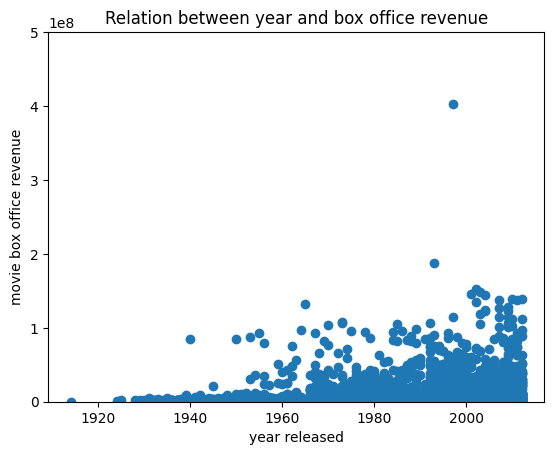

In [22]:
# plot the relation between year released and revenue after adjusting for inflation
plt.scatter(movies["year_released"], movies["movie_box_office_revenue"])
plt.title("Relation between year and box office revenue")
plt.xlabel("year released")
plt.ylabel("movie box office revenue")

# removing outlier for better visualization
plt.ylim(0, 0.5e9)
plt.show()

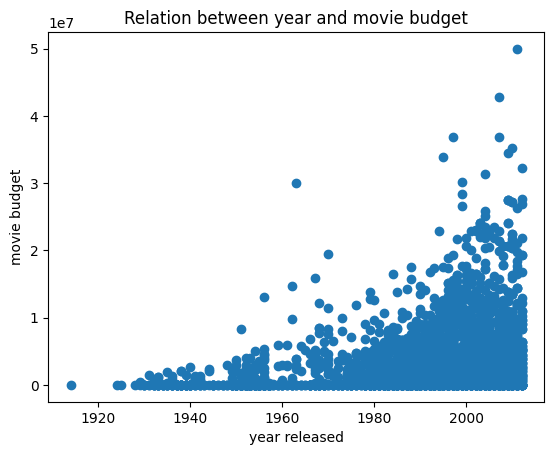

In [23]:
# plot the relation between year released and budget after adjusting for inflation
plt.scatter(movies["year_released"], movies["budget"])
plt.title("Relation between year and movie budget")
plt.xlabel("year released")
plt.ylabel("movie budget")
plt.show()

#### Comment
- we observe that the correlation between year and revenue is almost gone.

### Statistics
#### Correlation 
We use the Spearman Correlation Coefficient to calculate if there is a correlation between the year and the box office revenue. 

In [24]:
# correlation between year and revenue
stats.spearmanr(movies["release_year"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.014542411674691457, pvalue=0.4005983585658969)

- This result confirms or observation in the previous section. The correlation between year and revenue is almost gone.

#### ANOVA
In the next step we want to find if there is a best month to release a movie in terms of box office revenue. Therefore, we group the data into the different release months and check if there a significants differences between these means. To check for significant differences we perform a One-way ANOVA test.

In [25]:
# create a list storing the revenue for each month
month_data_list = [
    month_data[month_data["release_month"] == i]["movie_box_office_revenue"]
    for i in range(1, 13)
]

# perform f_oneway
res = stats.f_oneway(*month_data_list)

# print result
print(res)

F_onewayResult(statistic=12.417157050350212, pvalue=2.6411426257377103e-23)


#### Comment
- Since the p-value is < 0.05 we reject the null hypothesis that the means for each month is equal.
- This result tells us that the month of realease have an impact on the movie box office revenue.

In [26]:
# use independent t-test to check the difference between one month and the rest
results = []
months = [
    "dummy_val",
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

for i in range(1, 13):

    # divide into two populations, the month we are interested in and the rest
    month = month_data[month_data["release_month"] == i]
    all_other = month_data[month_data["release_month"] != i]

    # perform t-test
    result = stats.ttest_ind(
        month["movie_box_office_revenue"], all_other["movie_box_office_revenue"]
    )

    # perform independent t-test
    results.append({"statistic": result[0], "pvalue": result[1]})

result_df = pd.DataFrame(results, index=months[1:])
result_df

,statistic,pvalue
January,-4.240402,2.291660e-05
February,-2.163451,3.057720e-02
March,-0.196784,8.440085e-01
April,-1.001311,3.167492e-01
May,5.090415,3.770246e-07
June,6.407316,1.688559e-10
July,3.015946,2.581081e-03
August,-2.782004,5.432762e-03
September,-4.272063,1.990738e-05
October,-3.027778,2.482403e-03


In [27]:
# print the statistical significant months
result_df_signif = result_df[result_df["pvalue"] < 0.05]
result_df_signif

,statistic,pvalue
January,-4.240402,2.291660e-05
February,-2.163451,3.057720e-02
May,5.090415,3.770246e-07
June,6.407316,1.688559e-10
July,3.015946,2.581081e-03
August,-2.782004,5.432762e-03
September,-4.272063,1.990738e-05
October,-3.027778,2.482403e-03
November,2.924858,3.469336e-03


In [28]:
# print the non-statistical significant months
result_df_non_signif = result_df[result_df["pvalue"] > 0.05]
result_df_non_signif

,statistic,pvalue
March,-0.196784,0.844008
April,-1.001311,0.316749
December,1.125857,0.260307


#### Comment
- We observe that most of the months have statistical significant different means when comparing to all the other months
- We observe that June has the lowest p-value.
- The results tells us that the month of release can have a big impact on the revenue.

---
# Diversity

- This notebook intends to investigate the diversity of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the distribution of ethnicities and gender and how it correlates with a movie's revenue.

---
**Summary**
- Diverse movies have, on average, ~62% higher movie box office revenue.
- Movies with the majority of male actors have, on average, ~68.8% higher movie box office revenue.
- The results are intriguing, and we would like to pursue this aspect in further analysis in milestone 3.

<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Processing" data-toc-modified-id="Data Processing">Data Processing</a></span>
<li><a href="#Distributions" data-toc-modified-id="Distributions">Distributions</a></li>
<li><a href="#Gender" data-toc-modified-id="Gender">Gender</a></li>
<li><a href="#Ethnicity" data-toc-modified-id="Ethnicity">Ethnicity</a></li>

![Diversity](./img/diversity.jpeg)

---
## Distributions

---
### Distribution of actors

In [29]:
# add collumn for number of actors
num_actors = characters.groupby("freebase_movie_ID")["freebase_actor_ID"].apply(
    lambda x: x.count()
)

# rename the series
num_actors.name = "num_actors"

# merge with the movies data frame
movies = movies.merge(num_actors, left_on="freebase_movie_ID", right_index=True)

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,budget,id,release_date,tconst,averageRating,numVotes,date_given,release_year,release_month,num_actors
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.340194e+06,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,4.676770e+06,10016,2001-08-24 00:00:00+00:00,tt0228333,4.9,55271.0,True,2001.0,8.0,17


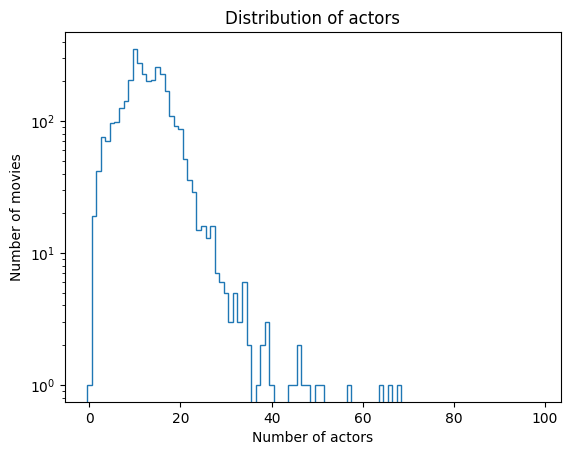

In [30]:
# plot the distribution of actors
bins = np.arange(100) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["num_actors"], histtype="step", bins=bins, log=True)
plt.xlabel("Number of actors")
plt.ylabel("Number of movies")
plt.title("Distribution of actors")
plt.show()

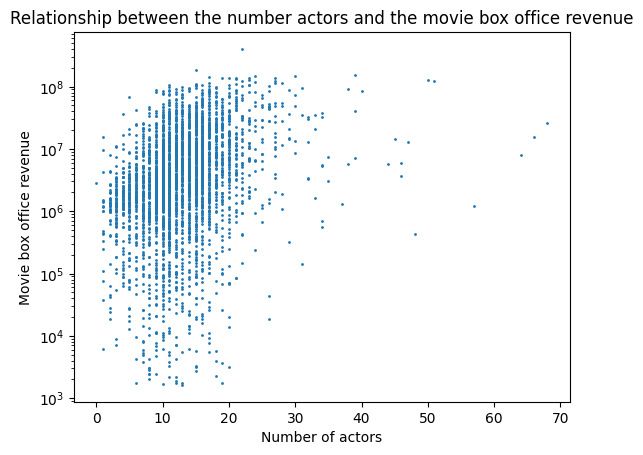

In [31]:
# plot relationship between 'num_actors' and 'movie_box_office_revenue'
movies.plot.scatter(x="num_actors", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Number of actors")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between the number actors and the movie box office revenue")
plt.show()

In [32]:
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_actors"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.3725898115948096, pvalue=1.6323376852477893e-109)

#### Comment

 **Problem:**
1. We observe that many movies only have a few actors. It´s unlikely that a movie only has one actor, which is the case for ~50 movies in the dataset. The reason is probably that the dataset initially focused on characters, which can be more difficult to extract than actors.

2. We observe that movies with more actors have higher revenue. This is something to be aware of since more actors will likely provide more diversity.

**Solution:**
1. A possible solution would be to collect data about the number of actors from a different dataset. The problem with an external dataset will be finding data about ethnicity and gender. This was not included in the [IMDb datasets](https://www.imdb.com/interfaces/).

2. It will be necessary to look at the number of ethnicities and females with the total number of actors.

**Conclusion:**
1. Setting a threshold for the number of actors is a good solution that still enables us to use the original dataset.

2. Computing an `ethnicity_score` and `fraction_of_female` to also consider the total number of actors.

---
### Threshold

Our previous finding suggested that a threshold on the number of actors might be necessary.

In [33]:
# filtering out movies with less than 10 actors
num_movies_before_filter = movies.shape[0]
movies = movies[movies["num_actors"] > 9]
num_movies_after_filter = movies.shape[0]

# printing the results
print(
    f"""
Total number of movies before filtering: {num_movies_before_filter}
Number of movies after filtering:        {num_movies_after_filter}     
"""
)


Total number of movies before filtering: 3310
Number of movies after filtering:        2432     



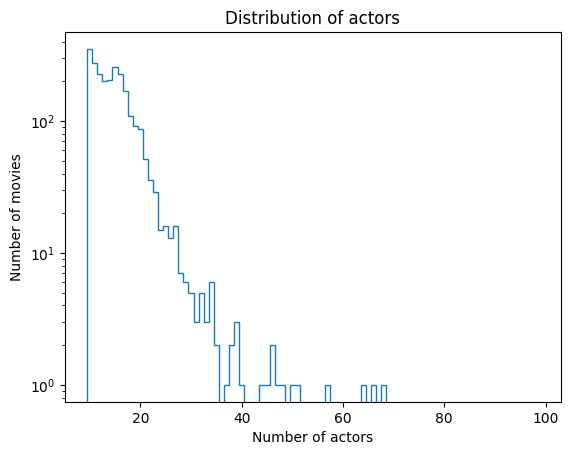

In [34]:
# plot the distribution of actors after threshold
bins = np.arange(10, 100) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["num_actors"], histtype="step", bins=bins, log=True)
plt.xlabel("Number of actors")
plt.ylabel("Number of movies")
plt.title("Distribution of actors")
plt.show()

In [35]:
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_actors"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.25901838822632084, pvalue=1.4070518098946903e-38)

#### Comment
There is still a statistically significant correlation between `num_actors` and `movie_box_office_revenue` after introducing a threshold, but the correlation is weakened.

---
## Ethnicity

---
### Correlation between the number of ethnicites and revenue

In [36]:
# add collumn for number of ethnicities
num_ethnicities = characters.groupby("freebase_movie_ID")["actor_ethnicity"].apply(
    lambda x: x.nunique()
)

# rename the series
num_ethnicities.name = "num_ethnicities"

# merge with the movies data frame
movies = movies.merge(num_ethnicities, left_on="freebase_movie_ID", right_index=True)

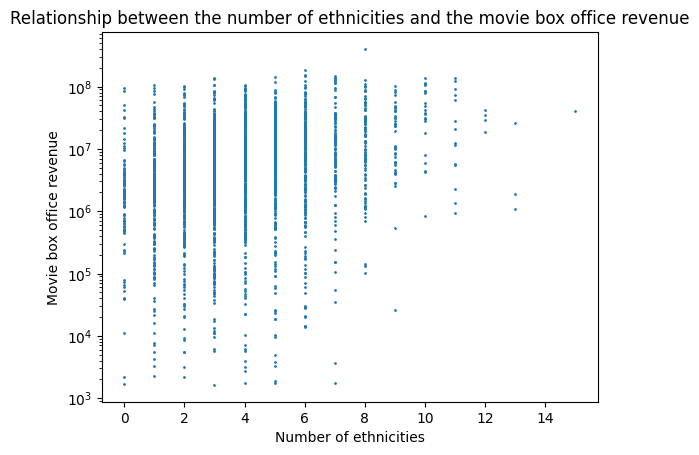

In [37]:
# plot relationship between 'num_ethnicities' and 'movie_box_office_revenue'
movies.plot.scatter(x="num_ethnicities", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Number of ethnicities")
plt.ylabel("Movie box office revenue")
plt.title(
    "Relationship between the number of ethnicities and the movie box office revenue"
)
plt.show()

In [38]:
# compute spearman correlation between 'num_ethnicities' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_ethnicities"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.2930829543420221, pvalue=2.2333303767023217e-49)

In [39]:
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_actors"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.25901838822632084, pvalue=1.4070518098946903e-38)

#### Comment
- We observe a significant correlation between `num_ethnicities` and `movie_box_office_revenue.`
- Further, we observe that the correlation between `num_actors` and `movie_box_office_revenue` is reduced after we filtered out movies with less than ten actors. This indicates that the number of actors has the most significant impact when there are few actors, e.g., increasing from 5 to 6 will have a more substantial effect on the revenue than rising from 14 to 15.
- It is still difficult to interpret how big impact `num_ethnicities` and `num_actors` have on `movie_box_office_revenue` separately since they are highly correlated.
- To try to isolate the impact ethnicities have on the revenue, we will instead look at an ethnicity_score, which is calculated as follow: $ethnicity\: score = \frac{number\,of\,ethnicities}{number\,of\,actors}$

---
### Correlation between the ethnicity score and revenue

In [40]:
# adding a collumn for num_etnicities / num_ectors
movies["ethnicity_score"] = movies["num_ethnicities"] / movies["num_actors"]

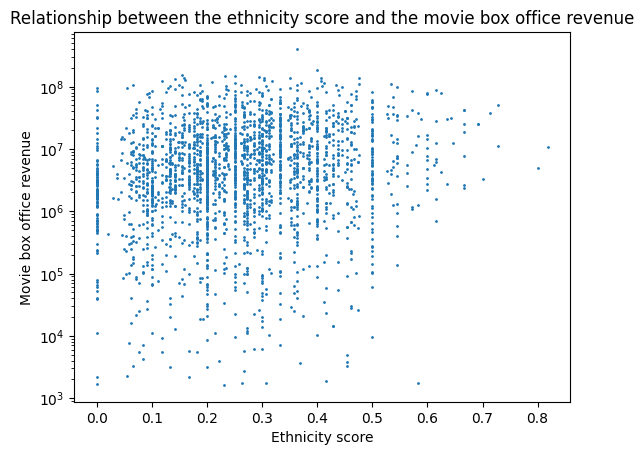

In [41]:
# plot relationship between 'ethnicity_score' and 'movie_box_office_revenue'
movies.plot.scatter(x="ethnicity_score", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Ethnicity score")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between the ethnicity score and the movie box office revenue")
plt.show()

In [42]:
# compute spearman correlation between 'ethnicity_score' and 'movie_box_office_revenue'
stats.spearmanr(movies["ethnicity_score"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.1812421119844799, pvalue=2.0962550326163798e-19)

#### Comment
- After trying to isolate the impact ethnicities have on the revenue, we still observe a significant correlation.

---
### Difference in revenue between the diverse and less diverse movies

In [43]:
# check difference between the revenue of movies with an without ethnicity score above 50
over_50_revenue = movies[movies["ethnicity_score"] > 0.5]["movie_box_office_revenue"]
under_50_revenue = movies[movies["ethnicity_score"] <= 0.5]["movie_box_office_revenue"]

In [44]:
# independent t-test
stats.ttest_ind(over_50_revenue, under_50_revenue)

Ttest_indResult(statistic=3.2478962063960752, pvalue=0.0011784472216188344)

In [45]:
# calculate the statistical power

# creating list to store the p-values
p_val = np.zeros(10000)

# running the simulation 10000 times
for i in range(10000):

    # sample over_50 and under_50
    sample_over_50 = np.random.choice(over_50_revenue, size=over_50_revenue.shape[0])
    sample_under_50 = np.random.choice(under_50_revenue, size=under_50_revenue.shape[0])

    # independent t-test
    p_val[i] = stats.ttest_ind(sample_over_50, sample_under_50)[1]

# calculating the percentage of rejects
power = len(p_val[p_val < 0.05]) / len(p_val)

# printing the results
print(
    f"""
The statistical power of:
    - The independent sample t-test comparing the revenue of diveres and less diverse movies: {power}
"""
)


The statistical power of:
    - The independent sample t-test comparing the revenue of diveres and less diverse movies: 0.8784



In [46]:
# calculating the mean difference
mean_diff_diversity = over_50_revenue.mean() - under_50_revenue.mean()

# performing bootstrap to get the 95% CI
diversity_CI = bootstrap_CI(over_50_revenue, under_50_revenue)

# printing the results
print(
    f"""
The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       {mean_diff_diversity}
    - CI:                         {diversity_CI}
"""
)


The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       7911560.791866973
    - CI:                         [2888352.6024155156, 13412664.727087187]



In [47]:
# calculating the average revenue for under_50
mean_under_50 = under_50_revenue.mean()

# calculating the percentage difference in revenue
diff_percent = mean_diff_diversity / mean_under_50

# printing the results
diff_percent

0.6198470999405525

#### Comment 
- The independent t-test gives us a small p-value (< 0.05), which indicates a statistically significant difference between the samples of diverse (ethnicity score > 0.5) and less diverse (ethnicity score ≤ 50) movies. The statistical power of the result is 0.8765. 
- Further, the mean difference shows that diverse movies generally have higher movie box office revenue. The confidence interval makes us confident in this result. 
- By dividing the average difference by the average revenue for less diverse movies, we get that diverse movie, on average, have a ~62% higher movie box office revenue. This shows that ethnicity is impactful on the movie box office revenue.

---
## Gender

---
### Correlation between the number of females and revenue

In [48]:
# checkint the amount of characters without 'actor_gender'
num_characters = characters.shape[0]
num_nan_gender = characters[characters["actor_gender"].isna()].shape[0]

# printing the results
print(
    f"""
Total number of characters:                {num_characters}
Number of characters without actor gender:  {num_nan_gender}     
"""
)


Total number of characters:                450669
Number of characters without actor gender:  45609     



In [49]:
# add collumn for fraction of females

# create frame with female actors
female_characters = characters[characters["actor_gender"] == "F"]

# add column for number of female actors
num_female = female_characters.groupby("freebase_movie_ID")["actor_gender"].count()

# rename the series
num_female.name = "num_female"
movies = movies.merge(num_female, left_on="freebase_movie_ID", right_index=True)

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,tconst,averageRating,numVotes,date_given,release_year,release_month,num_actors,num_ethnicities,ethnicity_score,num_female
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.340194e+06,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,tt0228333,4.9,55271.0,True,2001.0,8.0,17,3,0.176471,6


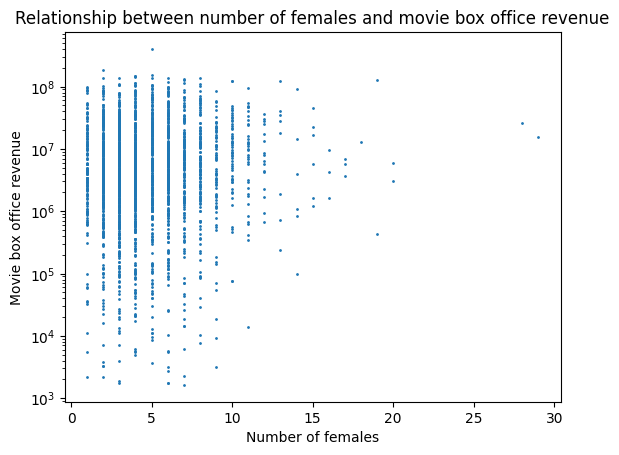

In [50]:
# plot relationship between 'num_female' and 'movie_box_office_revenue'
movies.plot.scatter(x="num_female", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Number of females")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between number of females and movie box office revenue")
plt.show()

In [51]:
# compute spearman correlation between 'num_female' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_female"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.06973637237746323, pvalue=0.0006543086836556279)

#### Comment 
- We observe a weak but significant correlation between `num_female` and `movie_box_office_revenue.`
- It is difficult to interpret how big an impact `num_female` and `num_actors` have on `movie_box_office_revenue` separately since they are highly correlated (more actors will likely lead to more female actors as well).
- To try to isolate the impact gender have on the revenue, we will instead look at the fraction of female, which is calculated as follow: $fraction\: of\: female = \frac{number\,of\,female}{number\,of\,actors}$

---
### Correlation between the fraction of females and revenue

In [52]:
# add column for fraction of females
movies["frac_female"] = movies["num_female"] / movies["num_actors"]

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,averageRating,numVotes,date_given,release_year,release_month,num_actors,num_ethnicities,ethnicity_score,num_female,frac_female
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.340194e+06,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,4.9,55271.0,True,2001.0,8.0,17,3,0.176471,6,0.352941


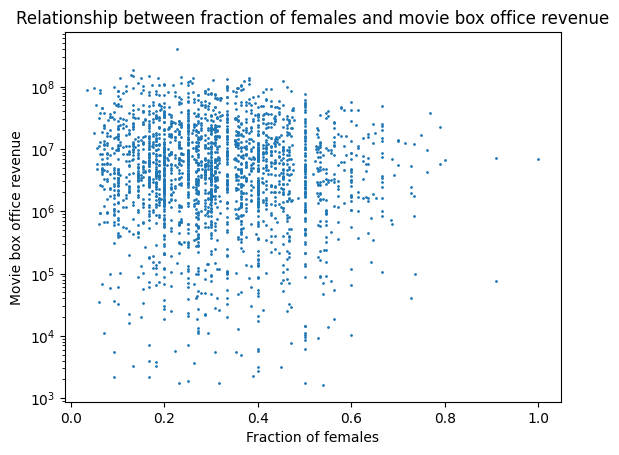

In [53]:
# plot relationship between 'frac_female' and 'movie_box_office_revenue'
movies.plot.scatter(x="frac_female", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Fraction of females")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between fraction of females and movie box office revenue")
plt.show()

In [54]:
# compute spearman correlation between 'frac_female' and 'movie_box_office_revenue'
stats.spearmanr(movies["frac_female"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=-0.06497392201178222, pvalue=0.0014994603834831948)

#### Comment
- After trying to isolate the impact on the revenue, we still observe a significant correlation, but this time we observe a negative correlation. The correlation between `frac_females` and `movie_box_office_revenue` is weak.

---
### Difference in revenue between the movies with majority of male and female actors

In [55]:
# check difference between the revenue of movies with majority of men and majority of women
majority_male_revenue = movies[movies["frac_female"] <= 0.5]["movie_box_office_revenue"]
majority_female_revenue = movies[movies["frac_female"] > 0.5][
    "movie_box_office_revenue"
]

In [56]:
# independent t-test
stats.ttest_ind(majority_male_revenue, majority_female_revenue)

Ttest_indResult(statistic=3.4551753234062845, pvalue=0.0005595537782759403)

In [57]:
# calculate the statistical power

# creating list to store the p-values
p_val = np.zeros(10000)

# running the simulation 10000 times
for i in range(10000):

    # sample over_50 and under_50
    sample_majority_male = np.random.choice(
        majority_male_revenue, size=majority_male_revenue.shape[0]
    )
    sample_majority_female = np.random.choice(
        majority_female_revenue, size=majority_female_revenue.shape[0]
    )

    # independent t-test
    p_val[i] = stats.ttest_ind(sample_majority_male, sample_majority_female)[1]

# calculating the percentage of rejects
power = len(p_val[p_val < 0.05]) / len(p_val)

# printing the results
print(
    f"""
The statistical power of:
    - The independent sample t-test comparing the revenue of movies with majority of male and majority of female 
      actors: {power}
"""
)


The statistical power of:
    - The independent sample t-test comparing the revenue of movies with majority of male and majority of female 
      actors: 0.9981



In [58]:
# calculating the mean difference
mean_diff_gender = majority_male_revenue.mean() - majority_female_revenue.mean()

# performing bootstrap to get the 95% CI
gender_CI = bootstrap_CI(majority_male_revenue, majority_female_revenue)

# printing the results
print(
    f"""
The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       {mean_diff_gender}
    - CI:                         {gender_CI}
"""
)


The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       5539614.993729237
    - CI:                         [3803844.922275761, 7226480.577750136]



In [59]:
# calculating the average revenue for under_50
mean_majority_female = majority_female_revenue.mean()

# calculating the percentage difference in revenue
diff_percent = mean_diff_gender / mean_majority_female

# printing the results
diff_percent

0.6877737033064181

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples with the majority of male actors (fraction of females ≤ 0.5) and the samples with the majority of female actors (fraction of females > 50). The statistical power of 0.9973 makes us confident in this result.
- Further, the mean difference tells us that the movies with the majority of male actors generally have a higher movie box office revenue. The confidence interval makes us confident in this result. 
- By dividing the average difference by the average revenue for movies with the majority of female actors, we get that movies with the majority of male actors, on average, have a ~68.8% higher movie box office revenue. This shows that the gender-composition is impactful on the movie box office revenue.

# Cast

- This section intends to investigate the casts of the CMU Movie Summary Corpus dataset.
- The notebook will do some initial analyses to see how individual movie actors affects the box office revenue. The aim of the analysis is to get an idea of relevant methods we could use, and understand how we can handle the data and data size. 

---
**Summary**

- If we include all actors in a linear regression model, we exceed the maximum recursion depth running the model. In addition to this, we get multicollinearity problems if we do not restrict the amount of actors in our regression model. 
- By using all actors that have played in more than 10 movies as categorical predictors, our model explains 59% of the variance in box office revenue, with an adjusted R-squared equal to 50%. Using actors that have played in more than 15 movies as predictors explains 32% of the variance in box office revenue, with an adjusted R-squared equal to 27%.
- Among the actors (as predictors) with p-value < 0.05, Alan Rickman (Professor Severus Snape) received the highest coefficient in our linear regression model. PS: This is only initial analysis and we will explain why the result cannot be trusted yet. Spoiler alert: Confounders.

---
## Preprocessing

---
### Loading data

In [60]:
# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)

---
### Null Values

In [61]:
movies.isna().sum()

wikipedia_movie_ID              0
freebase_movie_ID               0
movie_name                      0
movie_release_date           6902
movie_box_office_revenue    73340
movie_runtime               20450
movie_languages                 0
movie_countries                 0
movie_genres                    0
dtype: int64

In [62]:
characters.isna().sum()

wikipedia_movie_ID                      0
freebase_movie_ID                       0
last_update                          9995
character_name                     257875
actor_DOB                          106145
actor_gender                        45609
actor_height                       295845
actor_ethnicity                    344611
actor_name                           1228
actor_age_at_movie_release         158113
freebase_character/actor_map_ID         0
freebase_character_ID              257865
freebase_actor_ID                     815
dtype: int64

#### Comment
Both box office revenue and freebase actor ID contain some Null values we want to remove before exploring the cast's effect on revenue made. 

In [63]:
# Removing characters/actors without freebase_actor_id
characters = characters[characters["freebase_actor_ID"].notna()]

# Removing movies without box_office_revenue
movies = movies[movies["movie_box_office_revenue"].notna()]

---
### Correcting for inflation

We want to compare movies of different years from 2000 to 2012, so we need to correct for inflation.

In [64]:
# adjusting the 'movie_box_office_revenue' for inflation
movies = correct_for_inflation(
    movies, INFLATION_PATH, "movie_box_office_revenue", start_year=2000, end_year=2012
)

---
### Filtering and merging
We will analyze our data to create a recipe for a successful movie. For this section, we want to explore if certain actors impact the success of a movie. We want to restrict the time interval to movies released after 2000. Then we get a higher fraction of actors still in the movie industry.

In [65]:
# Removing movies from before 2000
movies = movies[movies["movie_release_date"] >= "2000"]

In [66]:
# Merging movies with characters on wiki_id.
movies_characters = pd.merge(
    left=movies, right=characters, on=["wikipedia_movie_ID", "freebase_movie_ID"]
)

In [67]:
movie_count = movies_characters.shape[0]
unique_combos = movies_characters.value_counts(
    subset=["wikipedia_movie_ID", "freebase_actor_ID"], dropna=False
).shape[0]

print(
    """
    Total number of movies (with duplicates) in our merged dataset: {}
    Unique number of combinations of 'wikipedia_movie_ID' and 'freebase_actor_ID': {}
    """.format(
        movie_count, unique_combos
    )
)


    Total number of movies (with duplicates) in our merged dataset: 49799
    Unique number of combinations of 'wikipedia_movie_ID' and 'freebase_actor_ID': 49281
    


#### Comment
Some actors are listed mulitple times because they play different characters in the same movie. We only want unique combinations of `wikipedia_movie_ID` and `freebase_actor_ID`. 


In [68]:
# We filter out duplicated combinations of 'wikipedia_movie_ID' and 'freebase_actor_ID'.
# For now, we do not care which row/character we keep
movies_characters = movies_characters.drop_duplicates(
    subset=["wikipedia_movie_ID", "freebase_actor_ID"], keep="first"
)
movies_characters.shape

(49281, 20)

---
## Understanding Cast Data

In [69]:
# Number of unique movies
num_movies = movies_characters["wikipedia_movie_ID"].nunique()
print("Number of unique movies: {}".format(num_movies))

Number of unique movies: 3585


In [70]:
# Number of unique actors in dataset
num_actors_unique = movies_characters["freebase_actor_ID"].nunique()
print("Number of unique actors: {}".format(num_actors_unique))

Number of unique actors: 22934


In [71]:
# Checking number of actors in dataset, counting actors multiple times if they play
# in multiple movies
count_actors = movies_characters["freebase_actor_ID"].count()
print("Number of rows containing freebase actor ID: {}".format(count_actors))

Number of rows containing freebase actor ID: 49281


In [72]:
# Number of actors on average per movie
ratio = count_actors / num_movies
print("Number of actors on average per movie: {}".format(ratio))

Number of actors on average per movie: 13.746443514644351


---
## Exploring method: Linear Regression

---
### One Hot Encoding of Actors

In [73]:
# One Hot Encoding of Actors
movies_characters_dummy = pd.get_dummies(
    data=movies_characters, columns=["freebase_actor_ID"]
)
movies_characters_dummy.shape

(49281, 22953)

In [74]:
# Only include wikipedia movie ID and one hot encoding of actors in dataframe
dummy_actor_columns = movies_characters_dummy.filter(
    regex="wikipedia_movie_ID|freebase_actor_ID_"
)

In [75]:
# We want to try different thresholds for how many actors we include.
# Exploring actors that have played in more than 10 and 15 movies.
dummy_actor_columns15 = dummy_actor_columns.loc[:, dummy_actor_columns.sum(axis=0) > 15]
dummy_actor_columns10 = dummy_actor_columns.loc[:, dummy_actor_columns.sum(axis=0) > 10]
print(
    "Number of actors that have played in more than 10 movies: {}".format(
        dummy_actor_columns10.shape[1] - 1
    )
)
print(
    "Number of actors that have played in more than 15 movies: {}".format(
        dummy_actor_columns15.shape[1] - 1
    )
)

Number of actors that have played in more than 10 movies: 647
Number of actors that have played in more than 15 movies: 247


#### Comment
By only including actors that have played in more than 10 movies, we reduce the dataframe size from 22953 to 647. Reducing the threshold further to 15, we reduce the dataframe size from 22953 columns to 247 columns. This makes the linear regression possible without exceeding the maximum recursion depth. There might be actors excluded who actually have a big impact on revenue made, but for now, we want to explore the actors that have played in more than 15 movies. 

In [76]:
# Grouping movies such that every movie correspond to only one row in the dataframe
dummy_actor_columns10 = dummy_actor_columns10.groupby("wikipedia_movie_ID").agg("sum")
dummy_actor_columns15 = dummy_actor_columns15.groupby("wikipedia_movie_ID").agg("sum")

# Merging dummy actor columns with the movies
movies_binary_actors10 = pd.merge(
    movies, dummy_actor_columns10, left_on="wikipedia_movie_ID", right_index=True
)
movies_binary_actors15 = pd.merge(
    movies, dummy_actor_columns15, left_on="wikipedia_movie_ID", right_index=True
)
movies_binary_actors10.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,freebase_actor_ID_/m/011zd3,...,freebase_actor_ID_/m/0p_pd,freebase_actor_ID_/m/0pmhf,freebase_actor_ID_/m/0prfz,freebase_actor_ID_/m/0pz91,freebase_actor_ID_/m/0q9kd,freebase_actor_ID_/m/0sw6g,freebase_actor_ID_/m/0sz28,freebase_actor_ID_/m/0ywqc,freebase_actor_ID_/m/0z4s,freebase_actor_ID_/m/0zcbl
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,1.362575e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,...,0,0,0,0,0,0,0,0,0,0


---
### Linear Regression

In [77]:
# Removing slashes in column names to avoid error in regression.
movies_binary_actors10.columns = movies_binary_actors10.columns.str.replace("/", "")
dummy_actor_columns10.columns = dummy_actor_columns10.columns.str.replace("/", "")

movies_binary_actors15.columns = movies_binary_actors15.columns.str.replace("/", "")
dummy_actor_columns15.columns = dummy_actor_columns15.columns.str.replace("/", "")

In [78]:
# Constructing formula used for regression
# For now we only include actors as categorical predictors
# We have two scenarios:
# 1) All actors that have played in more than 10 movies
# 2) All actors that have played in more than 15 movies
formula10 = "movie_box_office_revenue ~ "
for col in dummy_actor_columns10.columns:
    formula10 += "C(" + col + ")+"

formula15 = "movie_box_office_revenue ~ "
for col in dummy_actor_columns15.columns:
    formula15 += "C(" + col + ")+"

formula10 = formula10[:-1]
formula15 = formula15[:-1]

In [79]:
# Linear regression
mod10 = smf.ols(formula=formula10, data=movies_binary_actors10)
res10 = mod10.fit()
res_summary10 = res10.summary()

mod15 = smf.ols(formula=formula15, data=movies_binary_actors15)
res15 = mod15.fit()
res_summary15 = res15.summary()

In [80]:
print(
    "Our model with actors that played in more than 10 movies gets R-squared = {:.2f}".format(
        res10.rsquared
    )
)
print("The corresponding adjusted R-squared is: {:.2f}\n".format(res10.rsquared_adj))

print(
    "Our model with actors that played in more than 15 movies gets R-squared = {:.2f}".format(
        res15.rsquared
    )
)
print("The corresponding adjusted R-squared is: {:.2f}".format(res15.rsquared_adj))

Our model with actors that played in more than 10 movies gets R-squared = 0.59
The corresponding adjusted R-squared is: 0.50

Our model with actors that played in more than 15 movies gets R-squared = 0.32
The corresponding adjusted R-squared is: 0.27


#### Comment
Our model with actors that have played in more than 10 movies explains 59% of the variance in  box office revenue. However, we have many variables included (actors), which could make our model look more accurate even if there are many actors poorly contributing in some way. The adjusted R-squared score (50%) may be telling us that some variables (actors) are not contributing to our model’s R-squared properly. 

When we only include actors that have played in more than 15 movies, we get a lower R-squared, but there will also be less multicollinearity problems. 

For now we have only used actors as predictors, so there are likely to be confounders. Confounders could be budget, genre, release_date and more. However, the large R-squared tells us that we should continue exploring how actors and cast affect the box office revenue. 

In [81]:
# Turning result summary into a dataframe
# (actors that have played in more than 15 movies)
res_as_html = res_summary15.tables[1].as_html()
summary_df = pd.read_html(res_as_html, header=0, index_col=0)[0]

In [82]:
# Only including actors with p-value < 0.05.
# Statistically significant actors
summary_df = summary_df[summary_df["P>|t|"] < 0.05]

# Sorting the dataframe in descending order according to coefficient
summary_df.sort_values(by="coef", ascending=False, inplace=True)

# The top 3 actors with highest coefficient
summary_df.head(3)

,coef,std err,t,P>|t|,[0.025,0.975]
C(freebase_actor_ID_m09y20)[T.1],209500000.0,29500000.0,7.099,0.0,152000000.0,267000000.0
C(freebase_actor_ID_m01f6zc)[T.1],190900000.0,30500000.0,6.255,0.0,131000000.0,251000000.0
C(freebase_actor_ID_m05qg6g)[T.1],170300000.0,26600000.0,6.416,0.0,118000000.0,222000000.0


In [83]:
# Checking the number 1 actor we received from our
# initial analysis (by only considering actors as predictor)

movies_characters[movies_characters["freebase_actor_ID"] == "/m/09y20"].sort_values(
    by="movie_box_office_revenue", ascending=False
).head(3)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,last_update,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
18865,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.016723e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""...",2011-07-07,Professor Severus Snape,1946-02-21,M,1.854,/m/0d7wh,Alan Rickman,65.0,/m/09lybcv,/m/0c2l5,/m/09y20
43430,667361,/m/03176f,Harry Potter and the Philosopher's Stone,2001-11-16,9.479643e+08,153.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2001-11-16,Professor Severus Snape,1946-02-21,M,1.854,/m/0d7wh,Alan Rickman,55.0,/m/02_752k,/m/0c2l5,/m/09y20
25443,667368,/m/031778,Harry Potter and the Chamber of Secrets,2002-11-03,8.414749e+08,174.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2002-11-03,Professor Severus Snape,1946-02-21,M,1.854,/m/0d7wh,Alan Rickman,56.0,/m/02_7528,/m/0c2l5,/m/09y20


#### Comment
We cannot be sure whether Alan Rickman aka Professor Severus Snape has the highest effect on box office revenue. However, Alan Rickman has performed  in several movies with extremely high box office revenue, so the result is an indication that our choice of method could be further explored to gain insight into what actors affect box office revenue the most. The most urgent improvement of the model is to include more predictors (both categorical and continous) to avoid confounders.








![snape](img/snape.jpeg)

# Runtime

- This section intends to investigate the runtime of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the distribution of runtime and how it correlates with a movie's revenue.

---
### Summary
- We cannot conclude there is a linear relationship between movie runtime and revenue.
- Blockbuster movies ($400 million+) have, on average, 10.1% longer runtime than non-blockbuster movies.
- Movies with short runtime (<80min) have 54.8% less revenue than non-short movies.

---
### Data Processing

---
#### Loading data

In [84]:
# Filter for movies with runtime
df_runtime = movies[movies["movie_runtime"].notnull()]

---
#### Outlier Removal
We will find outliers by calculating IQR and remove data outside the lower/upper bound.

In [85]:
# IQR
Q1 = np.percentile(df_runtime["movie_runtime"], 25)
Q3 = np.percentile(df_runtime["movie_runtime"], 75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Remove outlier
df_runtime = df_runtime[
    (df_runtime["movie_runtime"] >= lower) & (df_runtime["movie_runtime"] <= upper)
]
df_runtime.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,1.362575e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


---
### Distribution of runtime

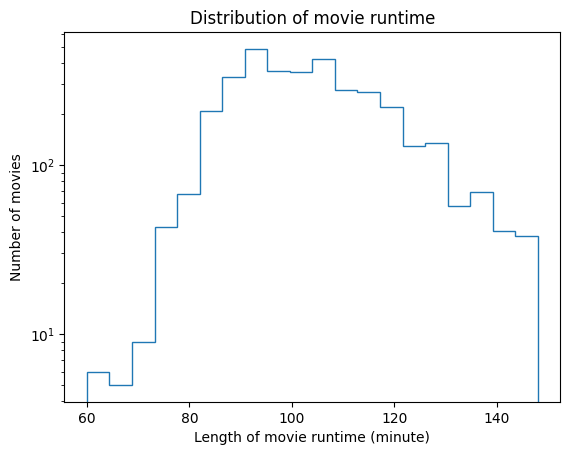

In [86]:
# histogram plot
plt.hist(df_runtime["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()

In [87]:
# Histogram for plotly
import plotly.express as px

fig = px.histogram(df_runtime, x="movie_runtime")
fig.update_layout(
    autosize=False,
    width=700,
    height=600,
    title="Distribution of movie runtime",
    xaxis_title="Length of movie runtime (minute)",
    yaxis_title="Number of movies",
)
fig.write_html("./runtime.html")

#### Comment

From the log histogram, we can see that most of the movies have runtime within the 85-120 minute interval.

---
### Regression & Scatterplot

In [88]:
runtime_model = smf.ols(
    "movie_box_office_revenue ~ movie_runtime", data=df_runtime
).fit()

# summarize our model
runtime_model_summary = runtime_model.summary()
runtime_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.035
Model:                                  OLS   Adj. R-squared:                  0.035
Method:                       Least Squares   F-statistic:                     129.1
Date:                      Wed, 21 Dec 2022   Prob (F-statistic):           2.10e-29
Time:                              21:42:32   Log-Likelihood:                -70330.
No. Observations:                      3537   AIC:                         1.407e+05
Df Residuals:                          3535   BIC:                         1.407e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.308e+07   1.22e+07     -6.783      0.000   -1.07e+08   -5.91e+07
movie_runtime  1.322e+06   1.16e+05     11.361      0.000    1.09e+06    1.55e+06
==============================================================================
Omnibus:                     3102.829   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106132.150
Skew:                           4.130   Prob(JB):                         0.00
Kurtosis:                      28.532   Cond. No.                         733.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

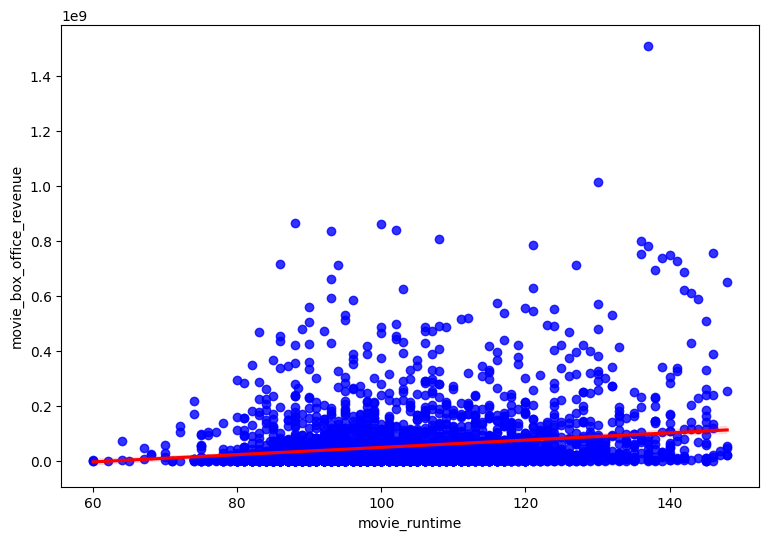

In [89]:
fig = plt.figure(figsize=(9, 6))

# pass in the model as the first parameter, then specify the
# predictor variable we want to analyze
fig = sns.regplot(
    x="movie_runtime",
    y="movie_box_office_revenue",
    data=df_runtime,
    ci=95,
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"},
)

#### Comment
- From the scatterplot, we see that there is a slight positive linear relationship between runtime and revenue. 
- However from previous regression analysis, the R squared value (0.035) is too small to justify the dependency between runtime and revenue. 
- We also see that movie with runtime between 80-120 minutes have similar distribution of revenue and movies with runtime less than 80 minutes generate less revenue (highet revenue is below $400000000). - Thus we can raise the question that if 80 minute could be a threshold for movie's revenue performance and we will address it in the next section.

---
### Effect of short runtime on revenue
We define **short** movie to have runtime < 80min\
and other (non-short) movie to have runtime >= 80min.

In [90]:
# Filter short movie to be under 80min
df_short = df_runtime[df_runtime["movie_runtime"] < 80]

# Filter non-short movie to be above or equal to 80min
df_non_short = df_runtime[df_runtime["movie_runtime"] >= 80]

In [91]:
# Plotly for overlay histogram of short vs non-short movies
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_short["movie_box_office_revenue"], name="Short movie"))
fig.add_trace(
    go.Histogram(x=df_non_short["movie_box_office_revenue"], name="Non-Short movie")
)
fig.update_yaxes(type="log")

# The two histograms are drawn on top of another
fig.update_layout(
    barmode="stack",
    autosize=False,
    width=700,
    height=600,
    title="Distribution of revenue of short vs non-short movies (log scale)",
    xaxis_title="Revenue",
    yaxis_title="Number of movies (log)",
)
fig.write_html("./mixed.html")

In [92]:
# independent t-test between short and non-short movies
stats.ttest_ind(
    a=df_short["movie_box_office_revenue"],
    b=df_non_short["movie_box_office_revenue"],
    equal_var=False,
)

Ttest_indResult(statistic=-5.823228019044849, pvalue=6.651763101800436e-08)

In [93]:
# calculate mean difference
mean_diff = (
    df_short["movie_box_office_revenue"].mean()
    - df_non_short["movie_box_office_revenue"].mean()
)

# print the mean difference
print(f"The mean difference in revenue is: {mean_diff}")

The mean difference in revenue is: -30297494.19941431


In [94]:
# calculating the percentage difference in revenue between the mean and non-short
diff_percent = mean_diff / df_non_short["movie_box_office_revenue"].mean()

# printing the results
diff_percent

-0.547776034906784

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.
- Further, the mean difference tells us that short movies (< 80min) generally generates less revenue than non-short (>=80min) movies.
- We can conclude that movies should not be too short as short movies have 54.8% less revenue than non-short movies.

---
### Difference in runtime between blockbuster vs. non-blockbuster
We define **blockbusters** as movies with revenue >= 400 million USD\
and **non-blockbusters** as movies with revenue < 400 million USD.

In [95]:
# Filter blockbuster movies
df_bb = df_runtime[df_runtime["movie_box_office_revenue"] >= 400000000]

# Filter non-blockbuster movies
df_non_bb = df_runtime[df_runtime["movie_box_office_revenue"] < 400000000]

In [96]:
# independent t-test
stats.ttest_ind(a=df_bb["movie_runtime"], b=df_non_bb["movie_runtime"], equal_var=False)

Ttest_indResult(statistic=4.84171950684262, pvalue=6.259113977597554e-06)

In [97]:
# calculate mean difference
mean_diff = df_bb["movie_runtime"].mean() - df_non_bb["movie_runtime"].mean()

# print the mean difference
print(f"The mean difference in runtime is: {mean_diff}")

The mean difference in runtime is: 10.45032801832454


In [98]:
# calculating the percentage difference in runtime between the mean and non-blockbuster
diff_percent = mean_diff / df_non_bb["movie_runtime"].mean()

# printing the results
diff_percent

0.1005474543881263

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that the blockbuster runtime is generally longer than non-blockbuster.  
- We can conclude that longer runtime are more successful, as blockbuster movies have 10.05% longer runtime than non-blockbuster movies. 

# Plot Summary

- This section intends to investigate the plot summary of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the sentiments within plot summary of movies and how they correlate with a movie's revenue.

---
### Summary
- We analyze plot summary from three sentiments: positive, negative and violent words and analyze if their proportion in plot summary affects revenue.
- Movies with more negative plot have on average 45.3% more revenue than those with more positive plots.
- Movies with more violent plot are more likely to generate revenue since blockbuster movies have 36.9% higher violent word porportion than non-blockbuster movies.

---
### Data Processing

---
#### Loading data

In [99]:
# Read summary data and filter movies with summary not null
df_summary = pd.read_csv(
    PLOT_SUMMARIES_PATH, sep="\t", header=None, names=["wikipedia_movie_ID", "summary"]
)
df_summary = df_summary[df_summary["summary"].notnull()]

In [100]:
# Merge metadata and summary data and filter for revenue and summary
df_merge = pd.merge(movies, df_summary, on=["wikipedia_movie_ID"], how="inner")
df_merge = df_merge[["wikipedia_movie_ID", "summary", "movie_box_office_revenue"]]
df_merge.head(5)

,wikipedia_movie_ID,summary,movie_box_office_revenue
0,975900,"Set in the second half of the 22nd century, th...",1.362575e+07
1,156558,A young 20-year-old named Jody lives with his...,2.857410e+07
2,12008535,"In the fictional farming village of Tlachtlán,...",8.871331e+06
3,5708633,The Great New Wonderful is a series of vignett...,1.469697e+05
4,3873713,"An officer in the violent crimes division, Dae...",4.176018e+06


---
#### Positive / Negative / Violent Vocab Collection
We decide to examine if positivity, negativity and violence in plot will affect movie revenue.\
First, we collect vocabulary with positive, negative and violent connotation.

In [101]:
# Sentiment List
sentiment = ["positive", "negative", "violent"]

In [102]:
# collecting the positive words list

# requesting the url
r = requests.get(POSITIVE_WORDS_PATH)

# extracting and decoding the content from the request
text = r.content.decode("us-ascii")

# extracting the text containing the positive words
pos_text = text.split("\n\n")

# converting the text into a list
pos_list = pos_text[1].split("\n")

In [103]:
# collecting the neagative words list

# requesting the url
r = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

# extracting and decoding the content from the request
text = r.content.decode("iso-8859-1")

# extracting the text containing the negative words
neg_text = text.split("\n\n")

# converting the text into a list
neg_list = neg_text[1].split("\n")

In [104]:
# collecting the violence words list
# source: https://myvocabulary.com/word-list/violence-vocabulary/

# Read from txt file
violent_file = open(VIOLENT_WORDS_PATH, "r")
violent_words = violent_file.read()

# Split into list
vio_list = violent_words.split(", ")

# Map every word into lower case
vio_list = list(map(lambda x: x.lower(), vio_list))

---
#### Positive / Negative / Violent proportion in summary
We calculate the proportion of words with positive / negative / violent connotation out of all words in movie summary.

In [105]:
# adding column for positive sentiment
df_merge["positive"] = df_merge["summary"].apply(lambda x: check_summary(x, pos_list))

# adding a columns for negative sentiment
df_merge["negative"] = df_merge["summary"].apply(lambda x: check_summary(x, neg_list))

# adding a columns for violent sentiment
df_merge["violent"] = df_merge["summary"].apply(lambda x: check_summary(x, vio_list))

In [106]:
df_merge.head(2)

,wikipedia_movie_ID,summary,movie_box_office_revenue,positive,negative,violent
0,975900,"Set in the second half of the 22nd century, th...",1.362575e+07,0.005602,0.044818,0.033613
1,156558,A young 20-year-old named Jody lives with his...,2.857410e+07,0.007837,0.032915,0.006270


---
### Regression & Scatterplot

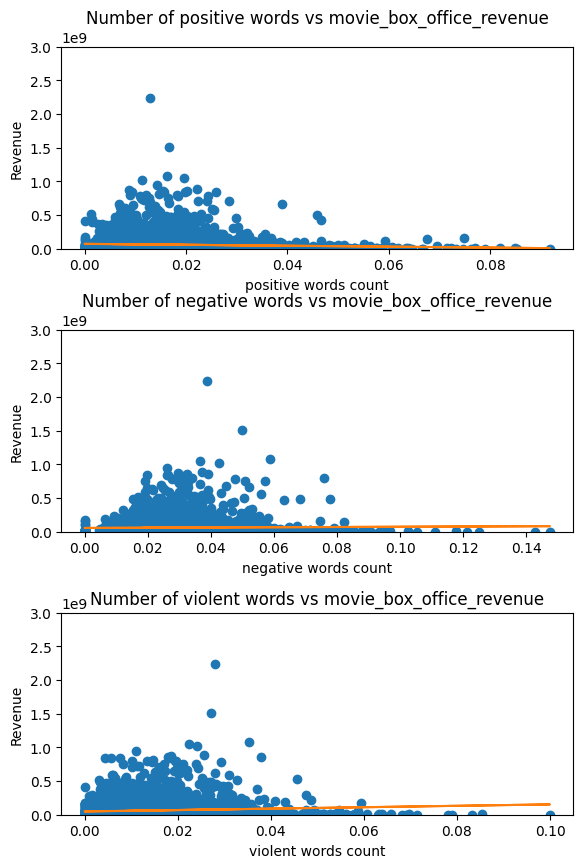

In [107]:
fig, ax = plt.subplots(3, 1)

# sentiment to ax position mapping
sen2ax = {"positive": ax[0], "negative": ax[1], "violent": ax[2]}

# Plot for each sentiment: positive, negative, violent
for s in sentiment:
    ax = sen2ax[s]
    ax.plot(df_merge[s], df_merge["movie_box_office_revenue"], "o")

    # obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(df_merge[s], df_merge["movie_box_office_revenue"], 1)
    # add linear regression line to scatterplot
    ax.plot(df_merge[s], m * df_merge[s] + b)

    ax.set_title(f"Number of {s} words vs movie_box_office_revenue")
    ax.set_xlabel(f"{s} words count")
    ax.set_ylabel("Revenue")
    ax.set_ylim(0, 3000000000)

# Combine all the operations and display
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1.7, wspace=0.4, hspace=0.4)
plt.show()

In [129]:
# Plotly graphs for positive, negative and violent
fig = px.scatter(
    df_merge,
    x="positive",
    y="movie_box_office_revenue",
    trendline="ols",
    trendline_color_override="orange",
)
fig.update_layout(
    autosize=False,
    width=700,
    height=300,
    title="Positive word proportion vs Revenue",
    xaxis_title="Positive word proportion",
    yaxis_title="Revenue",
)
fig.write_html("./positive_scatter.html")

In [130]:
fig = px.scatter(
    df_merge,
    x="negative",
    y="movie_box_office_revenue",
    trendline="ols",
    trendline_color_override="orange",
)
fig.update_layout(
    autosize=False,
    width=700,
    height=300,
    title="Negative word proportion vs Revenue",
    xaxis_title="Negative word proportion",
    yaxis_title="Revenue",
)
fig.write_html("./negative_scatter.html")

In [131]:
fig = px.scatter(
    df_merge,
    x="violent",
    y="movie_box_office_revenue",
    trendline="ols",
    trendline_color_override="orange",
)
fig.update_layout(
    autosize=False,
    width=700,
    height=300,
    title="Violent word proportion vs Revenue",
    xaxis_title="Violent word proportion",
    yaxis_title="Revenue",
)
fig.write_html("./violent_scatter.html")

In [108]:
# Regression analysis for positive word proportion vs revenue
positive_revenue_model = smf.ols(
    "movie_box_office_revenue ~ positive", data=df_merge
).fit()
positive_revenue_model_summary = positive_revenue_model.summary()
positive_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                  0.004
Method:                       Least Squares   F-statistic:                     13.69
Date:                      Wed, 21 Dec 2022   Prob (F-statistic):           0.000220
Time:                              21:45:20   Log-Likelihood:                -68450.
No. Observations:                      3411   AIC:                         1.369e+05
Df Residuals:                          3409   BIC:                         1.369e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.382e+07   3.84e+06     19.233      0.000    6.63e+07    8.13e+07
positive   -6.932e+08   1.87e+08     -3.699      0.000   -1.06e+09   -3.26e+08
==============================================================================
Omnibus:                     3572.085   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           302421.238
Skew:                           5.112   Prob(JB):                         0.00
Kurtosis:                      47.981   Cond. No.                         87.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
# Regression analysis for negative word proportion vs revenue
negative_revenue_model = smf.ols(
    "movie_box_office_revenue ~ negative", data=df_merge
).fit()
negative_revenue_model_summary = negative_revenue_model.summary()
negative_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                  0.000
Method:                       Least Squares   F-statistic:                     1.419
Date:                      Wed, 21 Dec 2022   Prob (F-statistic):              0.234
Time:                              21:45:20   Log-Likelihood:                -68456.
No. Observations:                      3411   AIC:                         1.369e+05
Df Residuals:                          3409   BIC:                         1.369e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.671e+07   4.98e+06     11.391      0.000     4.7e+07    6.65e+07
negative    1.779e+08   1.49e+08      1.191      0.234   -1.15e+08    4.71e+08
==============================================================================
Omnibus:                     3562.924   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           298190.353
Skew:                           5.094   Prob(JB):                         0.00
Kurtosis:                      47.658   Cond. No.                         69.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
# Regression analysis for violent word proportion vs revenue
violence_revenue_model = smf.ols(
    "movie_box_office_revenue ~ violent", data=df_merge
).fit()
violence_revenue_model_summary = violence_revenue_model.summary()
violence_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.008
Model:                                  OLS   Adj. R-squared:                  0.008
Method:                       Least Squares   F-statistic:                     27.85
Date:                      Wed, 21 Dec 2022   Prob (F-statistic):           1.39e-07
Time:                              21:45:20   Log-Likelihood:                -68443.
No. Observations:                      3411   AIC:                         1.369e+05
Df Residuals:                          3409   BIC:                         1.369e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.835e+07   3.37e+06     14.345      0.000    4.17e+07     5.5e+07
violent     1.049e+09   1.99e+08      5.277      0.000    6.59e+08    1.44e+09
==============================================================================
Omnibus:                     3539.781   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291237.625
Skew:                           5.043   Prob(JB):                         0.00
Kurtosis:                      47.130   Cond. No.                         92.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comment
- From the scatterplot, we see that there is a negative linear relationship between positive word proportion and revenue. In contrast, there is a positive linear relationship between negative word proportion and revenue. There is also a positive linear relationship between violent word proportion and revenue. 
- However from previous regression analysis, the R squared value (0.004 - positive, 0.000 - negative, 0.008 - violent) is too small to justify the dependency between all sentiments and revenue. 
- We see a opposing relationship between positive and negative plots and we will discover if more positive plot or more negative plot can boost the revenue in the following section.

---
### Difference in revenues between movies with more positive and more negative plot
We will analyze if plots with more positive word proportions will generate more revenues than those with more negative word proportions. 

In [111]:
# Filter for movies that have higher proportion of positive words than negative words
df_pos_majority = df_merge[df_merge["positive"] > df_merge["negative"]]

# Filter for movies that higher proportion of negative words than positive words
df_neg_majority = df_merge[df_merge["negative"] > df_merge["positive"]]

In [112]:
# independent t-test
stats.ttest_ind(
    a=df_pos_majority["movie_box_office_revenue"],
    b=df_neg_majority["movie_box_office_revenue"],
    equal_var=False,
)

Ttest_indResult(statistic=-8.28348394865533, pvalue=2.2092283913535158e-16)

In [113]:
# calculate mean difference
mean_diff = (
    df_pos_majority["movie_box_office_revenue"].mean()
    - df_neg_majority["movie_box_office_revenue"].mean()
)

# print the mean difference
print(f"The mean difference in revenue is: {mean_diff}")

The mean difference in revenue is: -31406709.86504378


In [114]:
# calculating the percentage difference in revenue between the mean and negative
diff_percent = mean_diff / df_neg_majority["movie_box_office_revenue"].mean()

# printing the results
diff_percent

-0.4528277499073446

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.
- Further, the mean difference tells us that movies with more positive plot generally has less revenue than movies with more negative plot.
- We can conclude that movies with more negative plot are more successful, as movies with more negative plot have 45.3% more revenue than movies with more positive plot.

---
### Difference in sentiment proportion between blockbuster vs. non-blockbuster
We define **blockbusters** as movies with revenue >= 400 million USD\
and **non-blockbusters** as movies with revenue < 400 million USD.

In [115]:
# Filter blockbuster movies
df_bb = df_merge[df_merge["movie_box_office_revenue"] >= 400000000]

# Filter non-blockbuster movies
df_non_bb = df_merge[df_merge["movie_box_office_revenue"] < 400000000]

In [116]:
# For each sentiment
for s in sentiment:
    # independent t-test
    print(stats.ttest_ind(a=df_bb[s], b=df_non_bb[s], equal_var=False))

    # calculate mean difference
    mean_diff = df_bb[s].mean() - df_non_bb[s].mean()

    # print the mean difference
    print(f"The mean difference in proportion of {s} words in summary is: {mean_diff}")

    # calculating the percentage difference between the mean and non-blockbuster
    diff_percent = mean_diff / df_non_bb[s].mean()

    # printing the results
    print(
        f"The percentage mean difference in proportion of {s} words in summary between blockbuster and non-blockbuster is: {diff_percent * 100}%\n"
    )

Ttest_indResult(statistic=-2.078542559320034, pvalue=0.040001245878357274)
The mean difference in proportion of positive words in summary is: -0.001736023798142793
The percentage mean difference in proportion of positive words in summary between blockbuster and non-blockbuster is: -10.20374545805693%

Ttest_indResult(statistic=2.9920315288726673, pvalue=0.0034513940821241152)
The mean difference in proportion of negative words in summary is: 0.003724946254998286
The percentage mean difference in proportion of negative words in summary between blockbuster and non-blockbuster is: 12.441406064772288%

Ttest_indResult(statistic=5.282328421961364, pvalue=6.85828278420772e-07)
The mean difference in proportion of violent words in summary is: 0.0047763807057551785
The percentage mean difference in proportion of violent words in summary between blockbuster and non-blockbuster is: 36.92077163785768%



#### Positive
- The independent t-test for positive words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has smaller positive word proportion in summary than non-blockbuster.  
- We can conclude that less positive plot components are more successful, as blockbuster movies have 10.2% less positive word usage than non-blockbuster movies. 

#### Negative
- The independent t-test for negative words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has higher negative word proportion in summary than non-blockbuster.  
- We can conclude that more negative plot components are more successful, as blockbuster movies have 12.4% more negative word proportion than non-blockbuster movies. 

#### Violent
- The independent t-test for violent words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has higher violent word proportion in summary than non-blockbuster.  
- We can conclude that more violent plot components are more successful as blockbuster movies have 36.9% higher violent word proportion than non-blockbuster movies. 